<a href="https://www.kaggle.com/code/kangnurrohman/sentiment-analysis-disaster-tweet-with-cnn-1d?scriptVersionId=112669405" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Sentiment Analysis Disaster Tweet with CNN 1D

👋🏻 Welcome to my notebook!

We are here going to do sentiment analysis using with Disaster Tweets. We will make predictions whether disaster or not. If you find it helpful, please comment and upvote

Let's get started!

# Table Of Contents

* [1. Install Library](#1)
* [2. Import Library](#2)
* [3. Load Data](#3)
* [4. Exploratory Data Analysis](#4)
    - [4.1 Sentiment Distribution](#4.1)
* [5. Data Preparation](#5)
    - [5.1 Data Cleaning](#5.1)
    - [5.2 Handling Data Imbalance (Oversampling)](#5.2)
    - [5.3 Splitting Data](#5.3)
    - [5.4 Data Pre-Processing](#5.4)
     - [5.4.1 Tokenizer](#5.4.1)
     - [5.4.2 Sequence Normalization](#5.4.2)
* [6. Building Model](#6)
* [7. Train Model](#7)
* [8. Evaluate Model Performance](#8)
    - [8.1 Confusion Matrix](#8.1)
    - [8.2 ROC AUC](#8.2)
* [9. Result Prediction](#9)

<a id="1"></a>
## Install Library

In [1]:
!pip install contractions

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 5.2 MB/s eta 0:00:00


<a id="2"></a>
## Import Library

In [2]:
import re
import nltk
import tqdm
import unicodedata
import numpy as np
import contractions
import pandas as pd
import seaborn as sns
import tensorflow as tf 
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from keras.models import load_model
from nltk.tokenize import word_tokenize
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Activation, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 

<a id="3"></a>
## Load Data

In [3]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")[['text', 'target']]
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


In [5]:
train_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


<a id="4"></a>
## Exploratory Data Analysis

In [6]:
x = train_df.target.value_counts()
x

0    4342
1    3271
Name: target, dtype: int64

<a id="4.1"></a>
### Sentiment Distribution

Text(0, 0.5, 'sample')

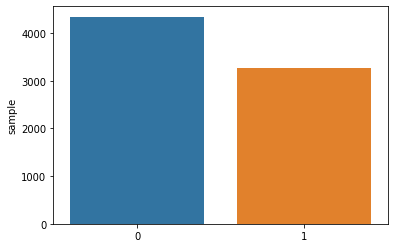

In [7]:
sns.barplot(x.index, x)
plt.gca().set_ylabel('sample')

<a id="5"></a>
## Data Preparation

<a id="5.1"></a>
### Data Cleaning

In [8]:
def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def stopwords_removal(words):
    list_stopwords = nltk.corpus.stopwords.words('english')
    #list_stopwords = stopwords.words('english')
    #list_stopwords.extend([])
    #txt_stopword = pd.read_csv("#", names= ["stopwords"], header = None)
    #list_stopwords.extend(txt_stopword["stopwords"][0].split(' '))
    return [word for word in words if word not in list_stopwords]

In [9]:
def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    #case folding
    doc = doc.lower()
    #remove special characters\whitespaces
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    #tokenize
    doc = word_tokenize(doc)
    #filtering
    doc = stopwords_removal(doc)
    norm_docs.append(doc)
  
  norm_docs = [" ".join(word) for word in norm_docs]
  return norm_docs

In [10]:
%%time
train_df.text = pre_process_corpus(train_df.text)

100%|██████████| 7613/7613 [00:04<00:00, 1640.64it/s]

CPU times: user 4.41 s, sys: 242 ms, total: 4.65 s
Wall time: 4.65 s


In [11]:
train_df.head()

,text,target
0,deeds reason earthquake may allah forgive us,1
1,forest fire near la ronge sask canada,1
2,residents asked shelter place notified officer...,1
3,13000 people receive wildfires evacuation orde...,1
4,got sent photo ruby alaska smoke wildfires pou...,1


<a id="5.2"></a>
### Handling Data Imbalance (Oversampling)

In [12]:
from sklearn.utils import resample
# Separate majority and minority classes in training data for upsampling 
data_majority = train_df[train_df.target == 0]
data_minority = train_df[train_df.target == 1]

print("majority class before upsample:",data_majority.shape)
print("minority class before upsample:",data_minority.shape)

# Upsample minority class
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples= data_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_balance = pd.concat([data_majority, data_minority_upsampled])
 
# Display new class counts
print("After upsampling\n",df_balance.target.value_counts(),sep = "")

majority class before upsample: (4342, 2)
minority class before upsample: (3271, 2)
After upsampling
0    4342
1    4342
Name: target, dtype: int64


<a id="5.3"></a>
### Splitting Data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_balance.text, df_balance.target, test_size=0.2, random_state=42)
X_train.shape , X_test.shape, y_train.shape, y_test.shape

((6947,), (1737,), (6947,), (1737,))

<a id="5.4"></a>
### Data Pre-Processing

<a id="5.4.1"></a>
#### Tokenizer

In [14]:
token = Tokenizer()
token.fit_on_texts(X_train)

In [15]:
vocab = len(token.index_word) + 1
print("Vocabulary size={}".format(len(token.word_index)))
print("Number of Documents={}".format(token.document_count))

Vocabulary size=18007
Number of Documents=6947


In [16]:
train_sequences = token.texts_to_sequences(X_train)
test_sequences = token.texts_to_sequences(X_test)

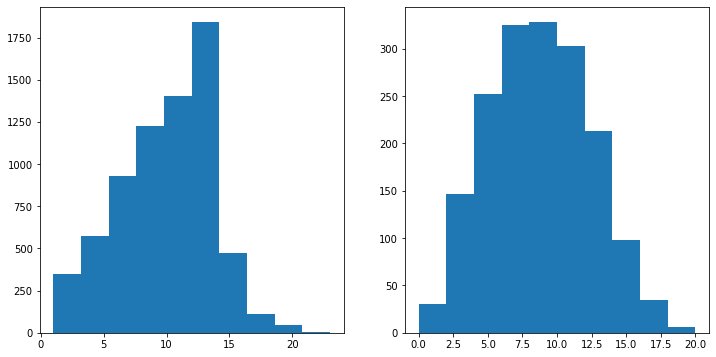

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

<a id="5.4.2"></a>
#### Sequence Normalization
Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length. For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [18]:
#padding
MAX_SEQUENCE_LENGTH = 30
X_train = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
X_test = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
X_train.shape, X_test.shape

((6947, 30), (1737, 30))

<a id="6"></a>
## Build Modelling

In [19]:
vec_size = 300
model = Sequential()
model.add(Embedding(vocab, vec_size, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(64,8, activation="relu"))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(16, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

2022-12-01 14:41:33.025965: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 300)           5402400   
_________________________________________________________________
conv1d (Conv1D)              (None, 23, 64)            153664    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 64)            0         
_________________________________________________________________
dense (Dense)                (None, 11, 16)            1040      
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 16)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 11, 8)             1

<a id="7"></a>
## Train Model

In [20]:
epochs = 100
batch_size = 16

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('./best_model/best_model_cnn1d.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit(X_train, y_train,  batch_size=batch_size, shuffle=True, validation_split=0.1, epochs=epochs, verbose=1, callbacks=[es, mc])

2022-12-01 14:41:33.408981: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
391/391 [==============================] - 19s 45ms/step - loss: 0.6067 - accuracy: 0.6457 - val_loss: 0.4717 - val_accuracy: 0.7842

Epoch 00001: val_accuracy improved from -inf to 0.78417, saving model to ./best_model/best_model_cnn1d.h5
Epoch 2/100
391/391 [==============================] - 17s 43ms/step - loss: 0.3506 - accuracy: 0.8594 - val_loss: 0.3974 - val_accuracy: 0.8245

Epoch 00002: val_accuracy improved from 0.78417 to 0.82446, saving model to ./best_model/best_model_cnn1d.h5
Epoch 3/100
391/391 [==============================] - 17s 45ms/step - loss: 0.1951 - accuracy: 0.9363 - val_loss: 0.4296 - val_accuracy: 0.8245

Epoch 00003: val_accuracy did not improve from 0.82446
Epoch 4/100
391/391 [==============================] - 17s 43ms/step - loss: 0.1035 - accuracy: 0.9650 - val_loss: 0.4310 - val_accuracy: 0.8259

Epoch 00004: val_accuracy improved from 0.82446 to 0.82590, saving model to ./best_model/best_model_cnn1d.h5
Epoch 5/100
391/391 [================

<a id="8"></a>
## Evaluate Model Performance

In [21]:
saved_model = load_model('./best_model/best_model_cnn1d.h5')
train_acc = saved_model.evaluate(X_train, y_train, verbose=1)
test_acc = saved_model.evaluate(X_test, y_test, verbose=1)
print('Train: %.2f%%, Test: %.2f%%' % (train_acc[1]*100, test_acc[1]*100))

55/55 [==============================] - 0s 4ms/step - loss: 0.7586 - accuracy: 0.8520
Train: 98.16%, Test: 85.20%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


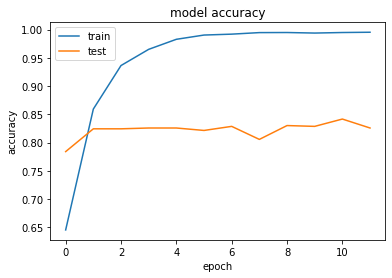

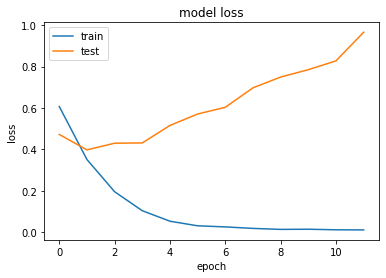

In [22]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
def get_encode(x):
    x = token.texts_to_sequences(x)
    x = pad_sequences(x, maxlen = MAX_SEQUENCE_LENGTH, padding="post")
    return x
def predictions(x):
    prediction_probs = model.predict(x)
    predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]
    return predictions

<a id="8.1"></a>
### Confusion Matrix

In [24]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

labels = ['positive', 'negative']
print(classification_report(y_test, predictions(X_test)))
pd.DataFrame(confusion_matrix(y_test, predictions(X_test)), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       857
           1       0.83      0.86      0.85       880

    accuracy                           0.84      1737
   macro avg       0.84      0.84      0.84      1737
weighted avg       0.84      0.84      0.84      1737



,positive,negative
positive,697,160
negative,119,761


<a id="8.2"></a>
### ROC AUC

In [25]:
def plot_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

model AUC score: 0.83903747215445


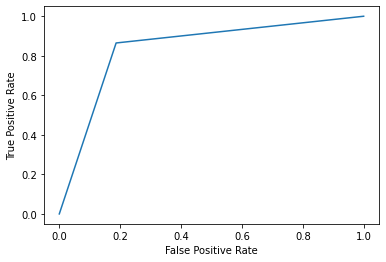

In [26]:
plot_roc_curve(y_test, predictions(X_test))
print(f'model AUC score: {roc_auc_score(y_test, predictions(X_test))}')

<a id="9"></a>
## Result Predictions

In [27]:
# Transformed into DataFrame
res = pd.DataFrame(
    {"id" : test_df['id'],
     "target": predictions(get_encode(test_df['text']))
    },
    columns=["id", "target"]).reset_index(drop=True)
#Dumping result
res.to_csv("result.csv", index=False)